영구 포트폴리오는 주식, 국채, 금, 현금을 각각 25%씩 투자하는 전략입니다. 이 비율을 변형하여 전략의 안정성을 크게 떨어뜨리지 않으면서 수익성을 개선하는 전략이 있습니다. 미국 기준으로 주식 20%, 소형 가치주 20%, 장기 국채 20%, 금 20%, 현금(단기 국채) 20% 비율로 투자하는 Goldenbutterfly(황금나비) 전략입니다.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
import math
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


금 ETF인 GLD가 2004-11-18 데이터부터 있으므로, 그 시점부터 시작합니다.

In [7]:
# VTI (미국 주식), VBR (미국 소형 가치주), TLT (미국 장기 국채), GLD (금), SHY (단기 국채)

start = '2004-11-18'
end = '2021-04-23'

vti = web.DataReader('VTI', 'yahoo', start, end)['Adj Close'].to_frame("vti_Close")
vbr = web.DataReader('VBR', 'yahoo', start, end)['Adj Close'].to_frame("vbr_Close")
tlt = web.DataReader('VUSTX', 'yahoo', start, end)['Adj Close'].to_frame("tlt_Close")
gld = web.DataReader('GLD', 'yahoo', start, end)['Adj Close'].to_frame("gld_Close")
shy = web.DataReader('SHY', 'yahoo', start, end)['Adj Close'].to_frame("shy_Close")

In [8]:
gld.head()

,gld_Close
Date,
2004-11-18,44.380001
2004-11-19,44.779999
2004-11-22,44.950001
2004-11-23,44.750000
2004-11-24,45.049999


일단 모델 포트폴리오로, 매일 20% 비중을 맞추는 것으로 생각하고 만듭니다. 거래비용은 생략합니다.

In [11]:
vti_return = vti.pct_change(periods=1)
vbr_return = vbr.pct_change(periods=1)
tlt_return = tlt.pct_change(periods=1)
gld_return = gld.pct_change(periods=1)
shy_return = shy.pct_change(periods=1)

df_return = pd.concat([vti_return, vbr_return, tlt_return, gld_return, shy_return], axis=1)

df_return.head()

,vti_Close,vbr_Close,tlt_Close,gld_Close,shy_Close
Date,,,,,
2004-11-17,NaN,NaN,NaN,NaN,NaN
2004-11-18,0.001563,-0.000884,0.003448,NaN,-0.000122
2004-11-19,-0.012137,-0.012212,-0.006873,0.009013,-0.001590
2004-11-22,0.006582,0.012184,0.004325,0.003796,0.000244
2004-11-23,0.000349,0.003363,-0.000861,-0.004449,-0.000122


In [12]:
df_return['GB_return'] = (df_return['vti_Close']+df_return['vbr_Close']+df_return['tlt_Close']+df_return['gld_Close']+df_return['shy_Close'])/5
df_return.head()

,vti_Close,vbr_Close,tlt_Close,gld_Close,shy_Close,GB_return
Date,,,,,,
2004-11-17,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-18,0.001563,-0.000884,0.003448,NaN,-0.000122,NaN
2004-11-19,-0.012137,-0.012212,-0.006873,0.009013,-0.001590,-0.004760
2004-11-22,0.006582,0.012184,0.004325,0.003796,0.000244,0.005426
2004-11-23,0.000349,0.003363,-0.000861,-0.004449,-0.000122,-0.000344


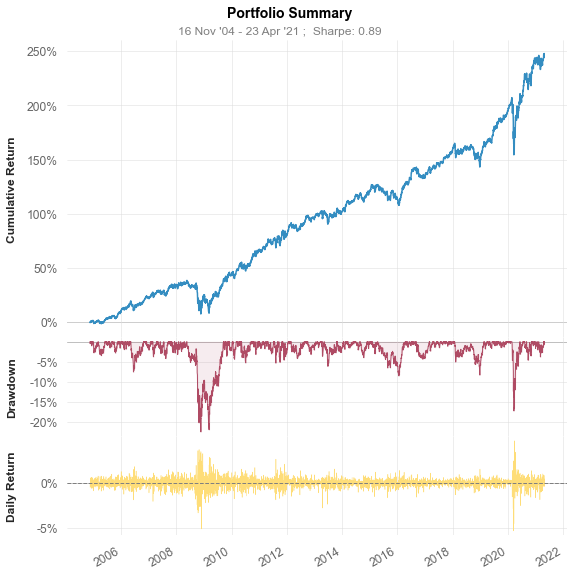

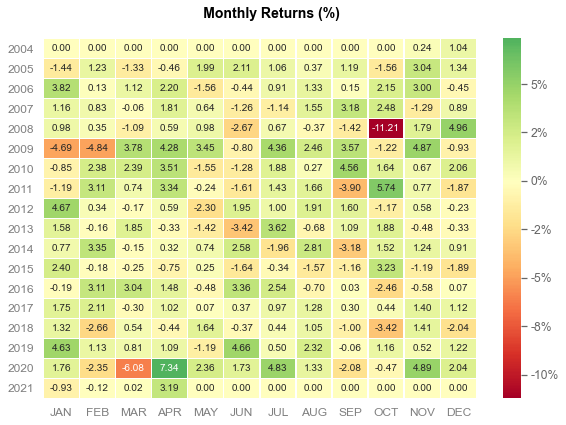

In [13]:
quantstats.reports.plots(df_return['GB_return'], mode='basic')

매일 리밸런싱을 한 결과 연 복리 수익률 7.88%, 샤프 비율 0.89, MDD -22.37% 정도입니다. 연 변동성 9.0%로 적당한 수익에 괜찮은 방어력을 보여주고 있습니다. 영구 포트폴리오보다는 샤프 비율이 낮아도 이 정도면 충분히 괜찮은 전략입니다. 

In [14]:
quantstats.reports.metrics(df_return['GB_return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-11-17
End Period                 2021-04-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          247.86%
CAGR%                      7.88%
Sharpe                     0.89
Sortino                    1.26
Max Drawdown               -22.37%
Longest DD Days            482
Volatility (ann.)          9.0%
Calmar                     0.35
Skew                       -0.4
Kurtosis                   10.9

Expected Daily %           0.03%
Expected Monthly %         0.63%
Expected Yearly %          7.17%
Kelly Criterion            8.37%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.9%
Expected Shortfall (cVaR)  -0.9%

Payoff Ratio               0.96
Profit Factor              1.18
Common Sense Ratio         1.15
CPC Index                  0.62
Tail Ratio                 0.98
Outlier Win Ratio          3.76
Outlier Loss Ratio         3.86



위에서 한 것처럼 그냥 만들어도 되지만, 백테스트에 많이 쓰이는 Backtrader 패키지를 한번 사용해 보겠습니다. Input 형식을 맞추어야 합니다.

In [15]:
vti = vti.rename({'vti_Close':'Close'}, axis='columns')
vbr = vbr.rename({'vbr_Close':'Close'}, axis='columns')
tlt = tlt.rename({'tlt_Close':'Close'}, axis='columns')
gld = gld.rename({'gld_Close':'Close'}, axis='columns')
shy = shy.rename({'shy_Close':'Close'}, axis='columns')

for column in ['Open', 'High', "Low"]:
    vti[column] = vti["Close"]
    vbr[column] = vbr["Close"]
    tlt[column] = tlt["Close"]
    gld[column] = gld["Close"]
    shy[column] = shy["Close"]

In [16]:
gld.head()

,Close,Open,High,Low
Date,,,,
2004-11-18,44.380001,44.380001,44.380001,44.380001
2004-11-19,44.779999,44.779999,44.779999,44.779999
2004-11-22,44.950001,44.950001,44.950001,44.950001
2004-11-23,44.750000,44.750000,44.750000,44.750000
2004-11-24,45.049999,45.049999,45.049999,45.049999


20% 비중을 맞추어 매수하고 20 거래일마다 리밸런싱하는 전략입니다. 20 거래일은 현실 기준으로 약 1개월입니다.

In [17]:
class AssetAllocation_GB(bt.Strategy):
    params = (
        ('assetclass',0.20),
    )
    def __init__(self):
        self.VTI = self.datas[0]
        self.VBR = self.datas[1]
        self.TLT = self.datas[2]
        self.GLD = self.datas[3]
        self.SHY = self.datas[4]
        self.counter = 0
        
    def next(self):
        if  self.counter % 20 == 0:
            self.order_target_percent(self.VTI, target=self.params.assetclass)
            self.order_target_percent(self.VBR, target=self.params.assetclass)
            self.order_target_percent(self.TLT, target=self.params.assetclass)
            self.order_target_percent(self.GLD, target=self.params.assetclass)
            self.order_target_percent(self.SHY, target=self.params.assetclass)
        self.counter += 1

In [18]:
cerebro = bt.Cerebro()

cerebro.broker.setcash(1000000)

VTI = bt.feeds.PandasData(dataname = vti)
VBR = bt.feeds.PandasData(dataname = vbr)
TLT = bt.feeds.PandasData(dataname = tlt)
GLD = bt.feeds.PandasData(dataname = gld)
SHY = bt.feeds.PandasData(dataname = shy)

cerebro.adddata(VTI)
cerebro.adddata(VBR)
cerebro.adddata(TLT)
cerebro.adddata(GLD)
cerebro.adddata(SHY)

cerebro.addstrategy(AssetAllocation_GB)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

#quantstats.reports.html(returns, output = 'Report_AssetAllocation_GoldenButterfly.html', title='AssetAllocation_GoldenButterfly')

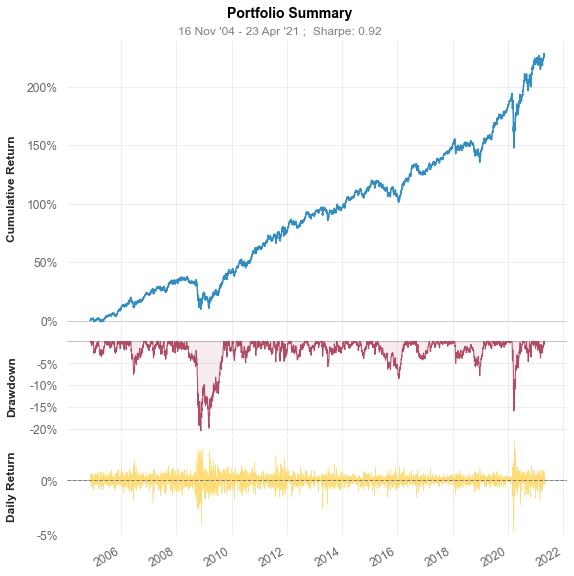

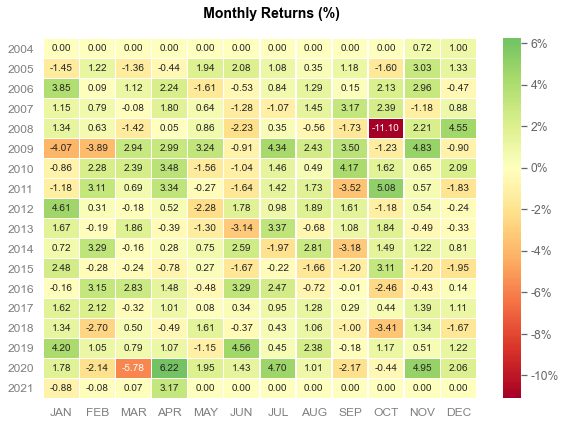

In [19]:
quantstats.reports.plots(returns, mode='basic')

20 거래일마다 리밸런싱으로 바꾸니 연 복리 수익률 7.5%, 샤프 비율 0.92, MDD -20% 수준입니다. 연 변동성 8.21%로 매일 리밸런싱보다 조금 더 안정적으로 변했습니다.

In [20]:
quantstats.reports.metrics(returns, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2004-11-17
End Period                 2021-04-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          228.43%
CAGR%                      7.5%
Sharpe                     0.92
Sortino                    1.31
Max Drawdown               -20.4%
Longest DD Days            483
Volatility (ann.)          8.21%
Calmar                     0.37
Skew                       -0.48
Kurtosis                   7.16

Expected Daily %           0.03%
Expected Monthly %         0.6%
Expected Yearly %          6.83%
Kelly Criterion            8.39%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.82%
Expected Shortfall (cVaR)  -0.82%

Payoff Ratio               0.96
Profit Factor              1.18
Common Sense Ratio         1.14
CPC Index                  0.62
Tail Ratio                 0.97
Outlier Win Ratio          3.67
Outlier Loss Ratio         3.86


월간 데이터를 사용하면 훨씬 더 과거의 결과도 테스트해 볼 수 있습니다. 가장 긴 시계열의 경우 1900년 1월부터 2020년 12월까지의 데이터가 있습니다.

In [21]:
MonthlyReturn = pd.read_excel('MonthlyAssetClassReturn.xlsx')

In [22]:
MonthlyReturn.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


시계열로 바꾸어 주는 것이 사용하기 편합니다. 1열인 Data Index가 월말 날짜이므로, 이 열을 인덱스로 잡습니다.

In [23]:
MonthlyReturn = MonthlyReturn.set_index('Data Index')

In [24]:
MonthlyReturn.head()

,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,GSCI,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
Data Index,,,,,,,,,,,,,,,,,,,,,
1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


필요한 것만 뽑아옵니다. 월간 미국 주식(S&P 500), 월간 미국 소형 가치주, 월간 미국 30년 만기 국채, 미국 단기 국채(T-Bill, 현금 대용), 금 수익률 데이터입니다. 1926년 7월부터 2020년 12월까지 94.5년 기간의 테스트가 될 것입니다.

In [25]:
Monthly_GB = MonthlyReturn.loc[:, ['S&P 500 Total return','Small Value','US 30 YR','GOLD','T-Bills']]
Monthly_GB = Monthly_GB.loc[Monthly_GB.index >= '1926-07-31']
Monthly_GB['Monthly_GB'] = (Monthly_GB['S&P 500 Total return']+Monthly_GB['Small Value']+Monthly_GB['US 30 YR']+Monthly_GB['GOLD']+Monthly_GB['T-Bills'])/5

월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1926년 7월부터 94.5년 동안 샤프 비율은 0.896으로 나옵니다. 상관관계가 매우 낮은 자산만 모아 놓아서 어느 시대이든 안정적으로 나오는 것을 볼 수 있습니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [26]:
quantstats.stats.sharpe(Monthly_GB['Monthly_GB'])/math.sqrt(252/12)

0.8964498650203416

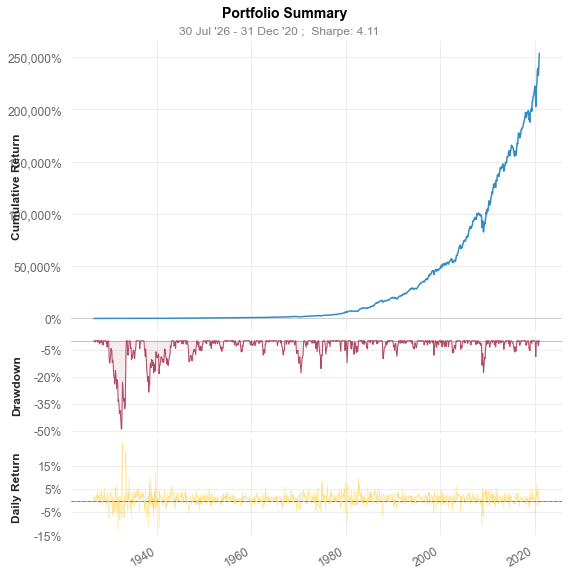

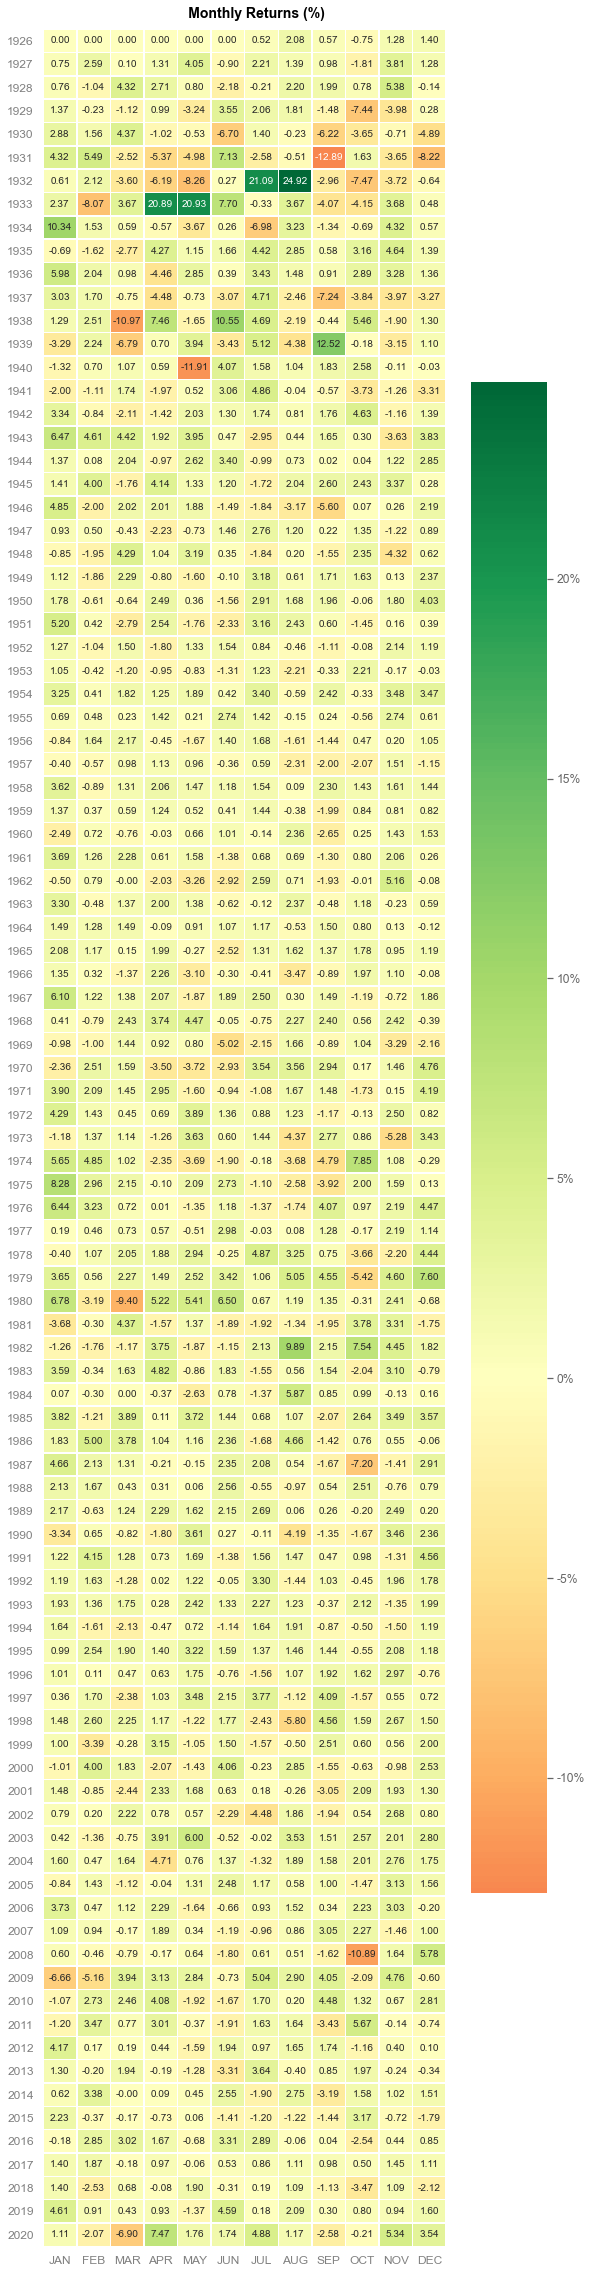

In [27]:
quantstats.reports.plots(Monthly_GB['Monthly_GB'], mode='basic')

연 복리 수익률 8.65%, 샤프 비율은 위에서 계산한대로 0.896 (아래 결과는 무시합니다 월간 데이터라 다르게 나옵니다), MDD는 대공황 시기를 넣고도 -49% 수준입니다. 방어력도 괜찮고 더 과거로 가니 수익률이 좋아졌습니다. 소형 가치주 성과가 과거에 더 좋았던 것 때문으로 보입니다. 94.5년을 버티면 원금이 2538배가 됩니다.

In [28]:
quantstats.reports.metrics(Monthly_GB['Monthly_GB'], mode='full')

                           Strategy
-------------------------  -----------
Start Period               1926-07-31
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          253,758.92%
CAGR%                      8.65%
Sharpe                     4.11
Sortino                    7.35
Max Drawdown               -49.25%
Longest DD Days            2132
Volatility (ann.)          44.96%
Calmar                     0.18
Skew                       1.11
Kurtosis                   12.74

Expected Daily %           0.69%
Expected Monthly %         0.69%
Expected Yearly %          8.6%
Kelly Criterion            34.37%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.93%
Expected Shortfall (cVaR)  -3.93%

Payoff Ratio               1.16
Profit Factor              2.13
Common Sense Ratio         2.81
CPC Index                  1.6
Tail Ratio                 1.32
Outlier Win Ratio          3.56
Outlier Loss Ratio     